#### Summary:

Finalized Notebook for findMarkers and fGSEA for Mouse PDAC Data.


In [2]:
options(warn=-1)
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(enrichR))
suppressMessages(library(fgsea))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(stringr))
suppressMessages(library(Matrix))
suppressMessages(library(matrixStats))
suppressMessages(library(data.table))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(lattice))
suppressMessages(library(limma))
suppressMessages(library(scales))
suppressMessages(library(reshape2))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(future))
suppressMessages(library(forcats))
suppressMessages(library(shadowtext))

# Read in final object

In [2]:
indir = "/nfs/lab/projects/mouse_pdac"
rds_fp = file.path(indir,"230918_2sample_merged_with_celltypes_CAFs_no_mito.rds")
adata <- readRDS(rds_fp)

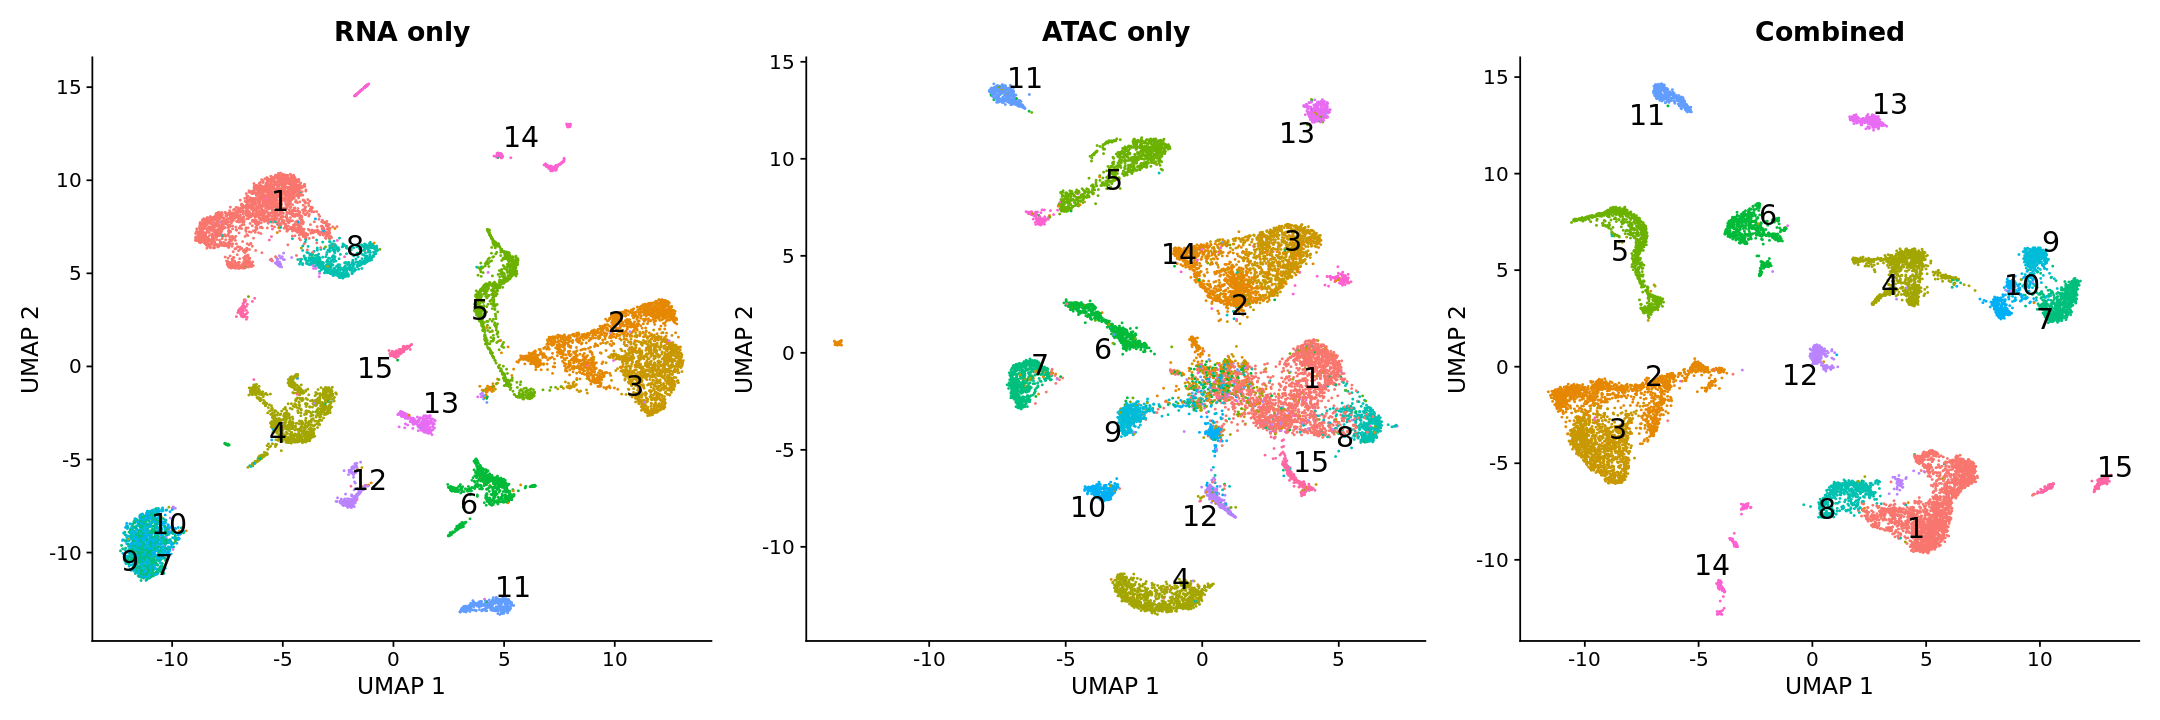

In [3]:
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

# Run findMarkers on major cell types (as reference)

In [ ]:
DefaultAssay(adata) <- 'SCT'

In [ ]:
outdir <- "/nfs/lab/projects/mouse_pdac/outputs/rna_findMarkers/celltype_markers"

celltypes <- sort(unique(adata$assigned_celltypes1))
Idents(adata) <- adata$assigned_celltypes1

for (celltype in celltypes){
    adata_sub <- subset(x = adata, idents = celltype)
    Idents(adata_sub) <- adata_sub$Genotype
    marker_genes <- FindMarkers(adata_sub, slot="data", ident.1="AKPC", ident.2="KPC", logfc.threshold=0, min.pct=0, verbose=TRUE)
    marker_genes <- marker_genes[order(-marker_genes$avg_log2FC),]
    # Create rank metric
    df <- marker_genes
    pseudocount <- min(df$p_val[df$p_val > 0])
    df$rank <- -log10(df$p_val + pseudocount) * df$avg_log2FC
    df <- df[order(df$rank, decreasing = T),]
    #then write to a file
    fp <- file.path(outdir, sprintf('%s_celltype_markers.txt',celltype))
    write.table(df, fp, sep='\t', quote=FALSE)
}

In [ ]:
# Fibroblast subtypes
outdir <- "/nfs/lab/projects/mouse_pdac/outputs/rna_findMarkers/celltype_markers"

celltypes <- c("apCAF", "iCAF", "myCAF")
Idents(adata) <- adata$Fibroblasts

for (celltype in celltypes){
    adata_sub <- subset(x = adata, idents = celltype)
    Idents(adata_sub) <- adata_sub$Genotype
    marker_genes <- FindMarkers(adata_sub, slot="data", ident.1="AKPC", ident.2="KPC", logfc.threshold=0, min.pct=0, verbose=TRUE)
    marker_genes <- marker_genes[order(-marker_genes$avg_log2FC),]
    # Create rank metric
    df <- marker_genes
    pseudocount <- min(df$p_val[df$p_val > 0])
    df$rank <- -log10(df$p_val + pseudocount) * df$avg_log2FC
    df <- df[order(df$rank, decreasing = T),]
    #then write that to a file
    fp <- file.path(outdir, sprintf('%s_celltype_markers.txt',celltype))
    write.table(df, fp, sep='\t', quote=FALSE)
}

# Run fGSEA on subtype markers

In [28]:
subpops = c("Acinar cells", "B cells", "Dendritic cells",
                      "Ductal cells", "EMT-like cells", "Endothelial cells",
                      "Fibroblasts", "Macrophages", "Neutrophils",
                      "Perivascular cells", "T and NK cells")

caf_subpops = c("apCAF", "iCAF", "myCAF")

In [29]:
# Read in pathways -- Hallmarks, go, reactome
hallmarks <- gmtPathways('/nfs/lab/projects/mouse_pdac/files/gene_sets/mh.all.v2023.1.Mm.symbols.gmt')

go <- gmtPathways('/nfs/lab/projects/mouse_pdac/files/gene_sets/m5.go.v2023.1.Mm.symbols.gmt')

reactome <- gmtPathways('/nfs/lab/ylee/mouse_pdac/m2.cp.reactome.v2023.1.Mm.symbols.gmt')

In [30]:
### Function which preps for and performs fGSEA for a set of differentially expr genes
### then outputs results to file
fGSEA_wrapper <- function(markers_dir, subtype, suffix, pathways, outdir){
    # Read in FindMarkers results and reorder
    fp <- file.path(markers_dir, sprintf('%s_celltype_markers.txt', subtype))
    df <- read.table(fp, sep='\t')

    # Create rank metric
    pseudocount <- min(df$p_val[df$p_val > 0])
    rank <- -log10(df$p_val + pseudocount) * df$avg_log2FC
    names(rank) <- rownames(df)
    num_infinite <- sum(is.infinite(rank)) # Sanity check for how many values were removed
    print(paste(subtype, "- Number of infinite values removed:", num_infinite))
    rank <- rank[is.finite(rank)] #Remove infinite values

    #Run fGSEA
    res <- fgsea(pathways = pathways, 
                 stats    = rank,
                 eps      = 0.0,
                 minSize  = 0,
                 maxSize  = 500)
    
    # Output results to a file (sorted by pval)
    out_fp <- file.path(outdir, sprintf('fGSEA.%s_findMarkers.%s.tsv', subtype, suffix))
    res_fin <- res[order(res$pval),]
    fwrite(res_fin, file=out_fp, sep="\t", sep2=c("", " ", ""))
}

In [37]:
# For bulk celltypes

## Change output directory here
outdir <- "/nfs/lab/projects/mouse_pdac/findMarkers"
markers_dir <- file.path(outdir,'celltype_markers')
fgsea_dir <- file.path(outdir,'/celltype_fGSEA')

# Change pathways here to pathway of interest
for (subpop in subpops){
    fGSEA_wrapper(markers_dir, subpop, 'go', go, fgsea_dir)
}

[1] "Acinar cells - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.74% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "B cells - Number of infinite values removed: 1"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Dendritic cells - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.78% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


[1] "Ductal cells - Number of infinite values removed: 1"
[1] "EMT-like cells - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (4.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Endothelial cells - Number of infinite values removed: 1"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.38% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Fibroblasts - Number of infinite values removed: 0"
[1] "Macrophages - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Neutrophils - Number of infinite values removed: 1"
[1] "Perivascular cells - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.47% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "T and NK cells - Number of infinite values removed: 1"


In [38]:
# For CAF subtypes

## Change output directory here
outdir <- "/nfs/lab/projects/mouse_pdac/findMarkers"
markers_dir <- file.path(outdir,'celltype_markers')
fgsea_dir <- file.path(outdir,'/celltype_fGSEA')

# Change pathways here to pathway of interest
for (subpop in caf_subpops){
    fGSEA_wrapper(markers_dir, subpop, 'go', go, fgsea_dir)
}

[1] "apCAF - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (20.8% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "iCAF - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (15.8% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "myCAF - Number of infinite values removed: 0"


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.09% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


## Plot fGSEA outputs

In [39]:
subpop_colors <- c('Acinar cells'='#251351', 'B cells'='#3B52A5', 'Dendritic cells'='#5AB1BB', 
                     'Ductal cells'='#618040', 'EMT-like cells'='#AFE079', 'Endothelial cells'='#FF773D',
                     'Fibroblasts'='#710CAB', 'Macrophages'='#CAA9DE', 'Neutrophils'='#D84727',
                     'Perivascular cells'='#EDA2C0', 'T and NK cells'='#E3C15D')

caf_subpop_colors <- c('apCAF'='#251351', 'iCAF'='#3B52A5', 'myCAF'='#5AB1BB')

In [40]:
### Short wrapper function for plots, reads in res from a fp and then filters for padj threshold
make_pathway_plots <- function(subpop, fp, threshold, colors){
    # Read in df and filter for significant results
    df <- read.table(fp, sep='\t', header=TRUE)
    df_sig <- na.omit(df[df$padj < threshold,])
    
    # Check if we have sig up/down pathways
    make_up_plot <- ifelse(dim(df_sig[df_sig$ES > 0,])[1] > 0, TRUE, FALSE)
    make_down_plot <- ifelse(dim(df_sig[df_sig$ES < 0,])[1] > 0, TRUE, FALSE)
    
    # Make two cell type colors
    color_down <- colors[[subpop]]
    color_up <- colorRampPalette(colors = c('black',color_down))(4)[3]

    # Call detailed function to make plots
    p1 <- gsea_up_dwn_plt_adapted(df_sig, str_to_title(subpop), color_up, color_down, 10, 1, 1, make_up_plot, make_down_plot)
    return(p1)
}

In [41]:
### Function to make fGSEA plots that takes in addition variables make_up_plot and make_down_plot
### boolean variables about whether to make the plots or not (aka if there are sig results or no)
### If not, returns blank plots, so we preserve formatting
gsea_up_dwn_plt_adapted <- function(data, celltype, colorup, colordown, numpathways, labelthreshup, labelthreshdown, make_up_plot, make_down_plot){
    data$LOG10P <- -log10(data$pval)
    data <- data[order(data$pval),]
    
    if (make_up_plot == TRUE){
        up_data <- data[which(data$ES > 0),][c(1:numpathways),]
        up_data$pathway <- factor(up_data$pathway, levels= up_data$pathway)
        up_data$pathway <- fct_rev(up_data$pathway)
        
        up_plt <- ggplot(up_data) +
                      geom_col(aes(LOG10P, pathway), fill= colorup, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(up_data$LOG10P, na.rm = TRUE)) + 0.5)),
                         breaks = seq(0, ceiling(max(up_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1),
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(up_data, LOG10P < labelthreshup),
                        aes(LOG10P, y = pathway, label = pathway),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = colorup,
                        bg.colour = 'white',
                        bg.r = 0.2,
                        size = 7) + 
                      geom_text(data = subset(up_data, LOG10P >= labelthreshup),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 7) +
                      labs(title = '', subtitle = paste0(celltype,' Up-Regulated Pathways -Log10(p-value)')) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    } else {
        up_plt <- ggplot(data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = paste0(celltype,' Up-Regulated Pathways -Log10(p-value)')) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), 
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    
    if (make_down_plot == TRUE){
        down_data <- data[which(data$ES < 0),][c(1:numpathways),]            
        down_data$pathway <- factor(down_data$pathway, levels= down_data$pathway)
        down_data$pathway <- fct_rev(down_data$pathway)
        
        down_plt <- ggplot(down_data) +
                      geom_col(aes(LOG10P, pathway), fill= colordown, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(down_data$LOG10P, na.rm = TRUE)) + 0.5)),
                         breaks = seq(0, ceiling(max(down_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), 
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(down_data, LOG10P < labelthreshdown),
                        aes(LOG10P, y = pathway, label = pathway),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = colordown,
                        bg.colour = 'white',
                        bg.r = 0.2,
                        size = 7) + 
                      geom_text(data = subset(down_data, LOG10P >= labelthreshdown),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,nudge_x = 0.2,colour = 'white',size = 7) +
                      labs(title = '', subtitle = paste0(celltype,' Down-Regulated Pathways -Log10(p-value)')) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    } else {
        down_plt <- ggplot(data) +
                    geom_blank() + 
                    labs(title = '', subtitle = paste0(celltype,' Down-Regulated Pathways -Log10(p-value)')) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1),
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    options(repr.plot.height = 10, repr.plot.width = 10)
    grid.arrange(up_plt, down_plt,nrow = 2)
}

In [5]:
# For bulk celltypes

# Change pathway to pathway of interest here
pathway <- "go"


# # Uncomment out to see all plots

# for (subpop in subpops){
#     fp <- file.path(outdir, 'celltype_fGSEA', sprintf('fGSEA.%s_findMarkers.%s.tsv', subpop, pathway))
#     make_pathway_plots(subpop, fp, 0.1, subpop_colors)
# }

In [4]:
# For CAF subtypes -- can skip if not needed

# Change pathway to pathway of interest here
pathway <- "go"

# # Uncomment out to see all plots

# for (subpop in caf_subpops){
#     fp <- file.path(outdir, 'celltype_fGSEA', sprintf('fGSEA.%s_findMarkers.%s.tsv', subpop, pathway))
#     make_pathway_plots(subpop, fp, 0.1, caf_subpop_colors)
# }

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/yuna/.conda/envs/multiome_pipeline/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shadowtext_0.1.3   forcats_1.0.0      future_1.33.0      RColorBrewer_1.1-3
 [5] ggrepel_0.9.5      ggpubr_0.6.0       ggplot2_3.4.4      reshape2_1.4.4    
 [9] scales_1.3.0       limma_3.54.2       lattice_0.22-5     gridExtra_2.3     
[13] data.table_1.14.10 matrixStats_1.2.0 